In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycirclize import Circos
from highlight_text import fig_text

In [2]:
endangered_status = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-12-23/endangered_status.csv")
languages = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-12-23/languages.csv")

In [3]:
endangered_status.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8567 entries, 0 to 8566
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            8567 non-null   object
 1   status_code   8567 non-null   int64 
 2   status_label  8567 non-null   object
dtypes: int64(1), object(2)
memory usage: 200.9+ KB


In [4]:
languages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8612 entries, 0 to 8611
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            8612 non-null   object 
 1   name          8612 non-null   object 
 2   macroarea     8388 non-null   object 
 3   latitude      8300 non-null   float64
 4   longitude     8300 non-null   float64
 5   iso639p3code  7856 non-null   object 
 6   countries     8510 non-null   object 
 7   is_isolate    8612 non-null   bool   
 8   family_id     8430 non-null   object 
dtypes: bool(1), float64(2), object(6)
memory usage: 546.8+ KB


In [5]:
# Merge dataframes
df = pd.merge(endangered_status, languages, on="id")

In [6]:
# Select relevant columns
df = df[["id", "status_label", "name", "macroarea", "countries"]]

In [7]:
# Checking missing macro areas
macro_missing=df[df["macroarea"].isna()]
macro_missing["countries"].unique()

array(['US', 'PG', 'AR', 'BR', 'ID', 'ID;PG', 'PE', 'CO', 'AU', 'BO',
       'MY', 'IQ', 'SB', 'MX', 'PY', 'CO;VE', 'TZ', 'PG;SB', 'ET', 'NG',
       'IN', 'VE', 'EC', 'IT', 'ML', 'TD', 'NP', 'CA;US', 'ES', 'BR;GY',
       'CA', 'IR', 'CL', 'TR', 'SD'], dtype=object)

In [8]:
# Lists for update macro area function
australia = ["AU"]
africa = ["ET", "ML", "NG", "SD", "TD", "TZ"]
eurasia = ["ES", "IN", "IQ", "IR", "IT", "MY", "NP", "TR"]
north_america = ["AR", "CA", "CA;US", "MX", "US"]
south_america = ["AR", "BO", "BR", "BR;GY", "CL", "CO", "CO;VE", "EC", "PE", "PY", "VE"]
papunesia = ["ID", "ID;PG", "PG", "PG;SB", "SB"]

In [9]:
# Function to create a new, updated macro area columns
def update_macroarea(df, macroarea, countries, australia, africa, eurasia, north_america, south_america, papunesia, macroarea_clean):
    # Create new column
    df["macroarea_clean"] = df["macroarea"]

    # Update macroarea, if missing, based on lists
    for i, row in df.iterrows():        
        if pd.isna(row["macroarea"]):
            if row["countries"] in australia:
                df.at[i, macroarea_clean] = "Australia"
            elif row["countries"] in africa:
                df.at[i, macroarea_clean] = "Africa"
            elif row["countries"] in eurasia:
                df.at[i, macroarea_clean] = "Eurasia"
            elif row["countries"] in north_america:
                df.at[i, macroarea_clean] = "North America"
            elif row["countries"] in south_america:
                df.at[i, macroarea_clean] = "South America"
            elif row["countries"] in papunesia:
                df.at[i, macroarea_clean] = "Papunesia"

    return df

In [10]:
# Apply the function
df = update_macroarea(df, "macroarea", "countries", australia, africa, eurasia, north_america, south_america, papunesia, "macroarea_clean")

In [11]:
# Select relevant columns
df = df[["id", "status_label", "macroarea_clean"]]

In [12]:
# Check new macro area column values
df["macroarea_clean"].value_counts()

macroarea_clean
Africa                          2275
Papunesia                       2160
Eurasia                         1893
North America                    731
South America                    689
Australia                        383
Africa;Eurasia                     4
Eurasia;Papunesia                  1
Africa;North America               1
Africa;Eurasia;South America       1
Name: count, dtype: int64

In [13]:
# Split values with semicolons into lists
df.loc[:, "macroarea_clean"] = df["macroarea_clean"].str.split(";")
# Explode lists into separate rows
df_exploded = df.explode("macroarea_clean").reset_index(drop=True)

In [14]:
df_exploded["macroarea_clean"].value_counts()

macroarea_clean
Africa           2281
Papunesia        2161
Eurasia          1899
North America     732
South America     690
Australia         383
Name: count, dtype: int64

In [15]:
# Grouping and counting
df_count = df_exploded.groupby(["macroarea_clean", "status_label"])["id"].count().reset_index()

In [16]:
# Function to insert line break where the string is more than 1 word
def insert_linebreak(value):
    if isinstance(value, str) and len(value.split()) > 1:
        return value.replace(" ", "\n")
    return value

# Apply the function 
df_count = df_count.map(insert_linebreak)

In [17]:
# Reshape dataframe
df_pivot = pd.pivot(df_count, index="macroarea_clean", columns="status_label", values="id").reset_index()

In [18]:
# Change some columns order
df_pivot = df_pivot[["macroarea_clean", "extinct", "moribund", "not\nendangered", "nearly\nextinct", "shifting", "threatened"]]

Followed the [documentation](https://moshi4.github.io/pyCirclize/chord_diagram/).

In [19]:
# Create matrix
row_names = df_pivot.macroarea_clean
col_names = df_pivot.columns[1:]
matrix_data = np.array(df_pivot.values[:, 1:])
matrix_df = pd.DataFrame(matrix_data, index=row_names, columns=col_names)

In [20]:
# Value counts per macro area
counts = df_exploded["macroarea_clean"].value_counts().reset_index()

In [21]:
# Sort values
counts = counts.sort_values(by="macroarea_clean")

In [22]:
# Create list of counted values
nums = counts["count"].to_list()

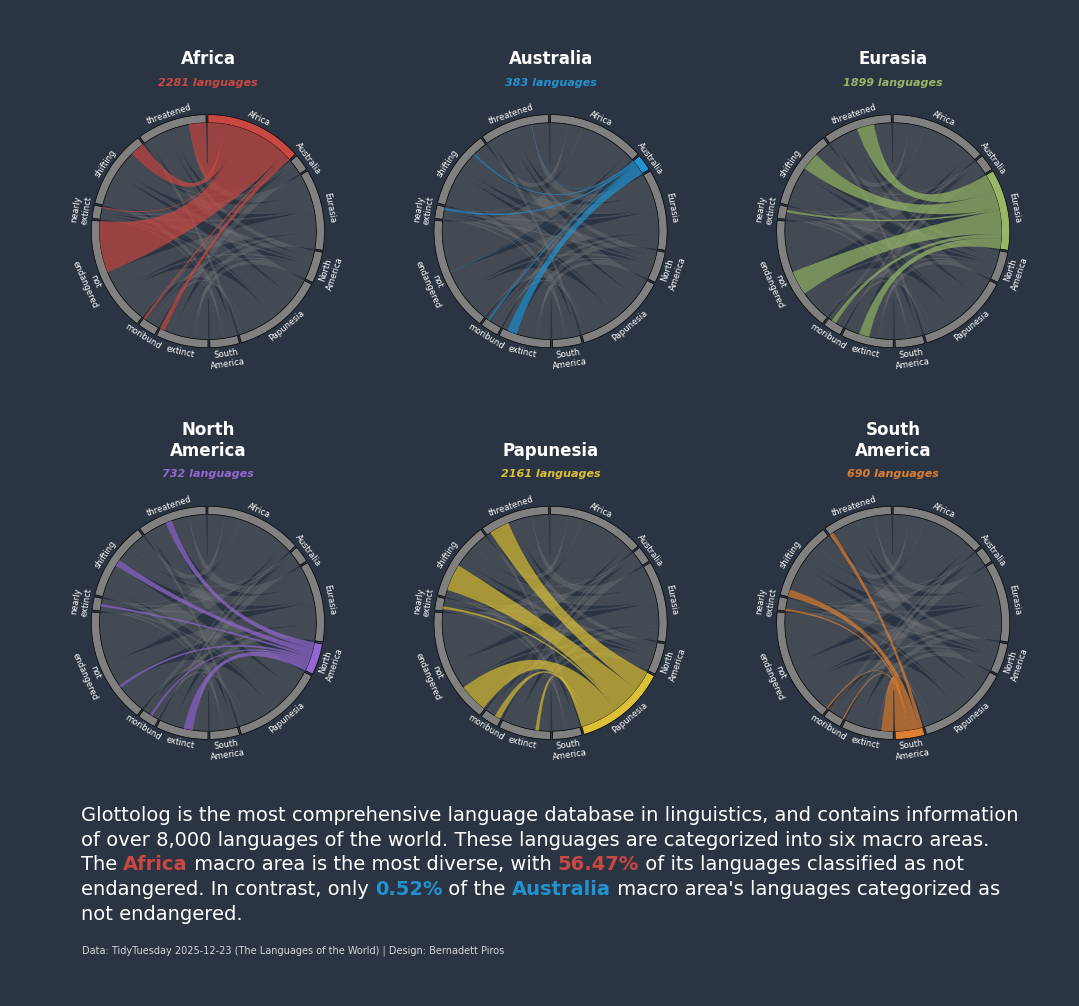

In [23]:
# Other text parameters
text_style=dict(weight="bold", color="white")

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 9), subplot_kw={"projection": "polar"}, facecolor="#2B3442")   
plt.subplots_adjust(hspace=0.3, wspace=0.4)
axs = axs.flatten()

# Colors for row highlights
palette = ["#C94942", "#2293D1", "#97B766", "#9368D1", "#DCC136", "#DD7F31"] 
highlight_colors = {row_name: palette[i % len(palette)] for i, row_name in enumerate(row_names)}
    
for i, (ax, n) in enumerate(zip(axs, nums)):
    # Sector to highlight 
    highlight_sector = matrix_df.index[i]    
    highlight_color = highlight_colors[highlight_sector]  
    # Subplot title and annotation
    ax.set_title(row_names[i], y=1.15, **text_style)
    ax.text(0, 125, f"{n} languages", color=highlight_color, fontstyle="oblique", weight="bold", size=8, ha="center")

    # Color mapping
    sector_colors = {sector: "grey" for sector in matrix_df.columns}
    sector_colors[highlight_sector] = highlight_colors[highlight_sector]  

    # Cmap for the chord diagram
    cmap_dict = {sector: "grey" for sector in matrix_df.columns}  
    cmap_dict[highlight_sector] = highlight_colors[highlight_sector]     
    
    # Define link_kws handler function to customize the links
    def link_kws_handler(from_label, to_label):
        if highlight_sector in {from_label, to_label}:              
            return dict(alpha=0.7, color=highlight_color, zorder=2.0)
        else:
            return dict(alpha=0.3, color="grey", zorder=0)  

    # Create chord diagram
    circos = Circos.chord_diagram(
        matrix_df, start=0, end=360, space=1, r_lim=(93, 100),
        cmap=cmap_dict, label_kws=dict(r=102, size=6, color="white"),
        link_kws_handler=link_kws_handler  
        )
                         
    circos.plotfig(ax=ax)     

txt = '''
    Glottolog is the most comprehensive language database in linguistics, and contains information
    of over 8,000 languages of the world. These languages are categorized into six macro areas.
    The <Africa> macro area is the most diverse, with <56.47%> of its languages classified as not
    endangered. In contrast, only <0.52%> of the <Australia> macro area's languages categorized as
    not endangered.    
    '''
# Add title
fig_text(0.1, 0.08, s=txt, color="white", size=14,
         highlight_textprops=[
             {"color": "#C94942", "weight":"bold"},
             {"color": "#C94942", "weight":"bold"}, 
             {"color": "#2293D1", "weight":"bold"}, 
             {"color": "#2293D1", "weight":"bold"}
             ],
         ax=ax)

# Add caption
fig.text(0.122, -0.09, "Data: TidyTuesday 2025-12-23 (The Languages of the World) | Design: Bernadett Piros", color="white", size=7, alpha=0.8)

# Show the plot    
plt.show()

#fig.savefig("2025-12-23.png", bbox_inches="tight", pad_inches=0.2)